In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import MDAnalysis as mda
from MDAnalysis.analysis.rms import RMSD
from MDAnalysis.analysis.rms import RMSF

# Ca-EF2 distance and RMSD calculation
The problem is that Ca2+ goes away from the protein and then enters another pocket. 

- RMSD: deviations of a subset of the atoms of the structure between two different frames ($r_1$ and $r_2$) of the trajectory. One of them is called *reference frame* (for example *r1*)
 - useful measure of structure similarity
 - basically the first thing to measure when you have Molecular Dynamics data
 
$$RMSD \ (r_1,r_2) = \sqrt{\frac{1}{N}\sum_{i=1}^{N} \frac{w_i}{\langle w \rangle}\delta_i^2} $$

where the indices $i$ run over the subset of selected atoms and $\delta_i$ is the deviation of atom $i$ in frame $r_2$ with respect to the position of atom $i$ in the reference frame $r_1$:

$$\delta_i^2 = |\vec{x}_{(2)i} - \vec{x}_{(1)i}|^2.$$


$w_i$ are weights that can be specified by the user. **What weights would make sense?**

A rigid rototranslation has to be performed, in which frame $r_2$ is superimposed over the reference frame in order to remove unimportant translations and rotations (6 degrees of freedom to superimpose two sets of points). In this way the RMSD is minimised.

In [2]:
PDB = 'start_prot_CAL.pdb'
XTC = 'trj_fit.xtc'
u = mda.Universe(str(PDB), str(XTC)) #we create the universe

PDB_aa = 'AA_sim/ref_nowat.pdb'
XTC_aa = 'AA_sim/trj_fit.xtc'
u_aa = mda.Universe(str(PDB_aa), str(XTC_aa))


/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [10]:
pocket = "resid 70-90"  
sel_pocket = u.select_atoms(pocket)

rmsd_pocket = mda.analysis.rms.RMSD(sel_pocket).run()
rmsd_all = mda.analysis.rms.RMSD(u.select_atoms("all")).run()

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


Text(0.5, 0, 'Time [ns]')

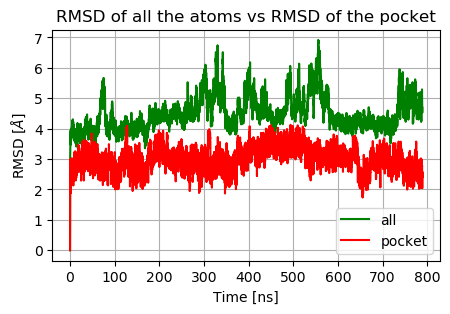

In [11]:
plt.rcParams["figure.figsize"] = (5, 3)
rmsd_pocket_values = rmsd_pocket.rmsd.T   # transpose makes it easier for plotting
rmsd_all_values = rmsd_all.rmsd.T   # transpose makes it easier for plotting
time = rmsd_all_values[1]
plt.plot(time*0.001, rmsd_all_values[2], 'g-',  label="all")
plt.plot(time*0.001, rmsd_pocket_values[2], 'r-',  label="pocket")
plt.ylabel(r"RMSD $[\AA]$")
plt.grid()
plt.legend(loc="best")
plt.title("RMSD of all the atoms vs RMSD of the pocket")
plt.xlabel("Time [ns]")

# Comparison with AA

In [42]:
rmsd_BB = mda.analysis.rms.RMSD(u.select_atoms("name BB")).run()
rmsd_CA_aa = mda.analysis.rms.RMSD(u_aa.select_atoms("name CA")).run()

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


Text(0.5, 0, 'Time [ns]')

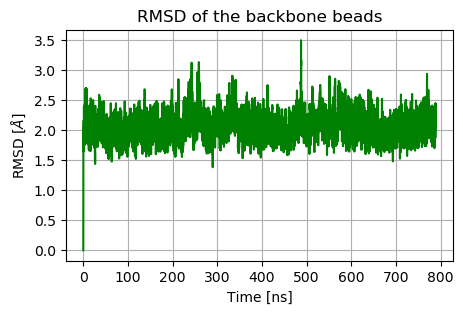

In [44]:
rmsd_BB_values = rmsd_BB.rmsd.T   # transpose makes it easier for plotting
time = rmsd_BB_values[1]
plt.plot(time*0.001, rmsd_BB_values[2], 'g-',  label="Backbone beads")
plt.ylabel(r"RMSD $[\AA]$")
plt.grid()
plt.title("RMSD of the backbone beads")
plt.xlabel("Time [ns]")

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


Text(0.5, 0, 'Time [ns]')

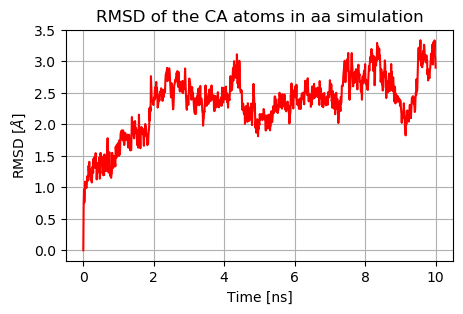

In [46]:
rmsd_CA_aa_values = rmsd_CA_aa.rmsd.T 
time_aa = rmsd_CA_aa_values[1]
plt.plot(time_aa*0.001, rmsd_CA_aa_values[2], 'r-',  label=r"C-$\alpha$")
plt.ylabel(r"RMSD $[\AA]$")
plt.grid()
plt.title("RMSD of the CA atoms in aa simulation")
plt.xlabel("Time [ns]")

# Root mean square fluctuation (RMSF)
We must treat the AA simulation with care since here it's all different. In fact, the landscape over which the protein moves is deeply modified, allowing for motions that maybe in the AA simulation are not accessible. 

It's somehow like treating two completely independent simulations, so the correspondences are not obvious. 

- measures the fluctuations of each atom with respect to the equlibrium
- proportional to the temperature ($\beta$) factor
- useful to match experimental results

## rmsf
$$RMSF_i = \left[\frac{1}{T}\sum_{t_j=1}^T |\mathbf{r}_i(t_j)-\mathbf{r}_i|^2\right]^{1/2}$$

Usually the reference is identified with the average position over the trajectory.
<br>
As in the case of RMSD calculations, you can compute RMSF over a subset of atoms. We will stick to the $C_{\alpha}$ atoms once again. This time we create an AtomGroup and use it in the calculation.

In [25]:
# devo distinguere la rmsd della backbone da quella totale 
# (che comprende anche le side-chains) 

all = u.select_atoms("all") # this is the AtomGroup
myRMSF_all = RMSF(all).run()

In [101]:
BB = u.select_atoms("name BB")
myRMSF_bb = RMSF(BB).run()

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


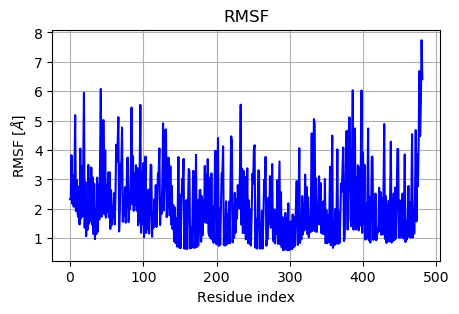

In [27]:
plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(myRMSF_all.rmsf[0:482], 'b')
plt.xlabel('Residue index')
plt.ylabel(r'RMSF [$\AA$]')
plt.title('RMSF (all the beads)')
plt.grid()

In [49]:
CA_aa = u_aa.select_atoms("name CA") # this is the AtomGroup
myRMSF_CA_aa = RMSF(CA_aa).run()

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)
/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


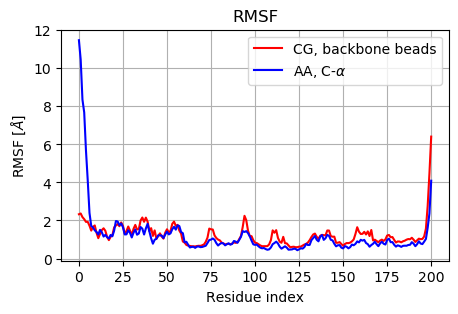

In [50]:
# potrei confrontare questa con quella AA

plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(myRMSF_bb.rmsf, 'r', label="CG, backbone beads")
plt.plot(myRMSF_CA_aa.rmsf, 'b', label=r"AA, C-$\alpha$")
plt.xlabel('Residue index')
plt.ylabel(r'RMSF [$\AA$]')
plt.title('RMSF')
plt.legend(loc='best')
plt.grid()

# Tieni conto che in realtà dovresti plottare la RMSF 
# rispetto agli atomi della backbone. 

In [81]:
len(u_aa.select_atoms("protein").residues)

201

In [94]:

rmsf_com = []

# Compute the CM of the reference configuration (frame zero)
com_coordinates_ref = []
for i in range(len(u_aa.select_atoms("protein").residues)):
    residue_group = u_aa.select_atoms(f"resid {i+2} and name CA N C")
    com_coordinates_ref.append(residue_group.center_of_mass())

In [95]:
for i in range(len(u_aa.select_atoms("protein").residues)):
    residue_group = u_aa.select_atoms(f"resid {i+2} and name CA N C")

    # define the array of positions 
    com_coordinates = np.zeros((len(u_aa.trajectory), 3))

    # Loop for the RMSF of a single residue 
    for ts in u_aa.trajectory:
        # Compute center of mass of the selected residue 
        com_coordinates[ts.frame] = residue_group.center_of_mass()

    # Compute the RMSF for the single residue    
    rmsf_com.append(np.mean(np.square(com_coordinates - com_coordinates_ref[i]), axis=0))
    print(f"RMSF of residue {i+2} computed")


# Nel caso dovesse esserci un errore ricordati che la numerazione dei 
# residui nella tua proteina è strana e parte da 2. Di conseguenza
# fai attenzione agli estremi del ciclo.


RMSF of residue 2 computed
RMSF of residue 3 computed
RMSF of residue 4 computed
RMSF of residue 5 computed
RMSF of residue 6 computed
RMSF of residue 7 computed
RMSF of residue 8 computed
RMSF of residue 9 computed
RMSF of residue 10 computed
RMSF of residue 11 computed
RMSF of residue 12 computed
RMSF of residue 13 computed
RMSF of residue 14 computed
RMSF of residue 15 computed
RMSF of residue 16 computed
RMSF of residue 17 computed
RMSF of residue 18 computed
RMSF of residue 19 computed
RMSF of residue 20 computed
RMSF of residue 21 computed
RMSF of residue 22 computed
RMSF of residue 23 computed
RMSF of residue 24 computed
RMSF of residue 25 computed
RMSF of residue 26 computed
RMSF of residue 27 computed
RMSF of residue 28 computed
RMSF of residue 29 computed
RMSF of residue 30 computed
RMSF of residue 31 computed
RMSF of residue 32 computed
RMSF of residue 33 computed
RMSF of residue 34 computed
RMSF of residue 35 computed
RMSF of residue 36 computed
RMSF of residue 37 computed


In [98]:
RMSF_aa = []
for i in range(len(u_aa.select_atoms("protein").residues)):
    RMSF_aa.append(math.sqrt(rmsf_com[i][0] + rmsf_com[i][1] + rmsf_com[i][2]))

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


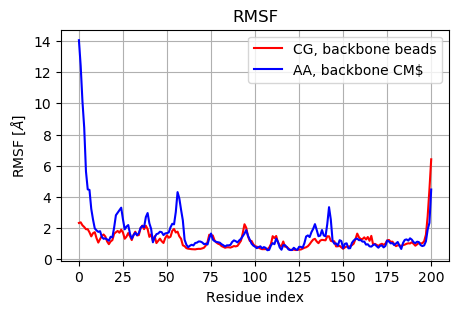

In [102]:
# plot 
plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(myRMSF_bb.rmsf, 'r', label="CG, backbone beads")
plt.plot(RMSF_aa, 'b', label="AA, backbone CM")
plt.xlabel('Residue index')
plt.ylabel(r'RMSF [$\AA$]')
plt.title('RMSF')
plt.legend(loc='best')
plt.grid()

# Radius of gyration (Rg)

The radius of gyration is defined as 
$$
R_g=\sqrt{\frac{\sum_i m_i \mathbf{r}_i^2}{\sum_i m_i}}
$$

The radius of gyration is a measure of the globularity of a protein. It is defined as the root mean square deviation of the position of the atoms with respect to the center of mass of the protein.

$R_g^{2} = \frac{1}{N} \sum_{i=1}^{N}({\bf r_i} - {\bf r_c})^2$

NB: in this approximation all the masses are assumed to be equal. In the case of heavy atoms of proteins this assumption is pretty much satisfied.

In [40]:
# Radius of gyration of the backbone beads
Rgyr = []
for ts in u.trajectory:
    Rgyr.append(BB.radius_of_gyration())

Rgyr_aa = []
for ts in u.trajectory:
    Rgyr_aa.append(CA_aa.radius_of_gyration())

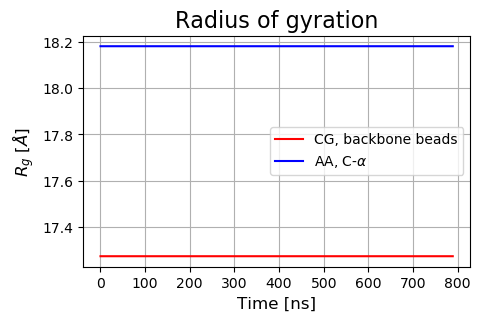

In [41]:
# qua bisogna tenere conto del mapping... La differenza è dovuta
# al fatto che il centro della bead non è proprio 

plt.plot(time*0.001, Rgyr, 'r', label="CG, backbone beads")
plt.plot(time*0.001, Rgyr_aa, 'b',  label=r"AA, C-$\alpha$")
plt.legend(loc="best")
plt.title("Radius of gyration",fontsize=16)
plt.xlabel("Time [ns]",fontsize=12)
plt.ylabel(r"$R_g$ [$\AA$]",fontsize=12)
plt.grid()